## Implementation of a simple Physics-Informed Neural Network

The aim of this file is to use a simple physics-informed Neural Network to find the solution $u \in C^{1,1}([0,3] \times \mathbb{R})$ of the transport equation

 \begin{equation}\partial_{t}u + v\partial_{x}u = 0\end{equation}

with $u(0,x) = \phi(x)$ for $t \in [0,3]$, $x \in \mathbb{R}$ and $v$ being a known velocity.

We follow the implementation of https://arxiv.org/abs/2310.20360, which is a simple PINN for a 2D heat equation. Here, we modify the code to solve a transport equation instead. We also choose to use a object-oriented structure which allows for better scalability to different velocities and initial conditions.

In [26]:
# Importing the necessary packages
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.autograd import grad
from matplotlib.gridspec import GridSpec
from matplotlib.cm import ScalarMappable
import numpy as np

In [27]:
# Sets the device to be used for PyTorch operations. We choose to prioritise GPUs.
dev = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [28]:
T = 3.0   # T is the final time: recall that we are working on the time interval [0,3]
M = 20000 # Size of training set

torch.manual_seed(0)

x_data = torch.randn(M, 1).to(dev) * 2
t_data = torch.rand(M, 1).to(dev) * T

In [29]:
# The initial value
def phi(x):
 return torch.exp(-torch.abs(x))

In [30]:
class PINN(nn.Module):
    def __init__(self, phi, velocity, batch_size, num_iterations):
        super(PINN, self).__init__()
        
        # Network architecture
        self.network = nn.Sequential(
            nn.Linear(2, 50), nn.SiLU(),     ## We use three hidden layers with 50 nodes.
            nn.Linear(50, 50), nn.SiLU(),    ## We also use the SiLU activation function, defined by SiLU(x) = x*sigmoid(x)
            nn.Linear(50, 50), nn.SiLU(),
            nn.Linear(50, 50), nn.SiLU(),
            nn.Linear(50, 1),
        ).to(dev)
        
        self.phi = phi
        self.velocity = velocity
        self.batch_size = batch_size
        self.num_iterations = num_iterations

        # We use the Adam optimizer
        self.optimizer = torch.optim.Adam(self.network.parameters(), lr=3e-4)

    # Forward propagation
    def forward(self, t, x):
        inputs = torch.hstack((t, x))
        return self.network(inputs)

    # Computing the loss
    def compute_loss(self, x, t):
        # Compute u(0, x) for each x in the batch
        u0 = self.forward(torch.zeros_like(t), x)
        initial_loss = (u0 - self.phi(x)).square().mean()
        
        # Compute the partial derivatives using automatic differentiation
        u = self.forward(t, x)
        ones = torch.ones_like(u)
        u_t = grad(u, t, ones, create_graph=True)[0]
        u_x = grad(u, x, ones, create_graph=True)[0]
        
        # Compute the loss for the PDE
        pde_loss = (u_t + torch.mul(self.velocity, u_x)).square().mean()
        
        # Compute the total loss
        loss = initial_loss + pde_loss
        return loss

    # Training the network
    def train_network(self, x_data, t_data):
        J = self.batch_size
        
        for i in range(self.num_iterations):
            # Choose a random batch of training samples
            indices = torch.randint(0, M, (J,))
            x = x_data[indices, :]
            t = t_data[indices, :]
            
            x.requires_grad_()    
            t.requires_grad_()

            self.optimizer.zero_grad()
            loss = self.compute_loss(x, t)
            loss.backward()
            self.optimizer.step()

        return self.network

# Example usage:
phi = lambda x: torch.exp(-torch.abs(x))
velocity = 1.0  # example value
batch_size = 256
num_iterations = 20000
M = 2000

# Instantiate the PINN model
pinn_model = PINN(phi, velocity, batch_size, num_iterations)

# Train the model
trained_network = pinn_model.train_network(x_data, t_data)

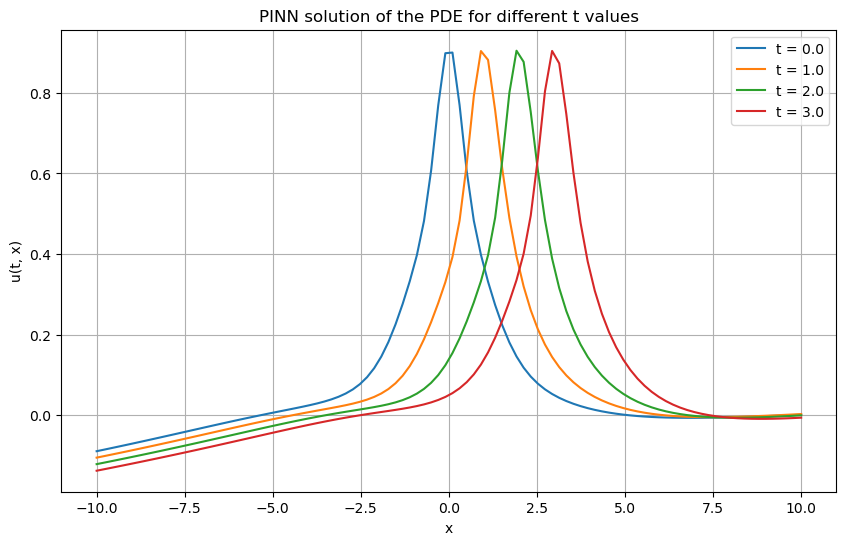

In [31]:
# Function to evaluate the network at given t and x values
def evaluate_network(N, t, x):
    with torch.no_grad():
        t_tensor = torch.tensor(t).float().to(dev)
        x_tensor = torch.tensor(x).float().to(dev)
        t_grid, x_grid = torch.meshgrid(t_tensor, x_tensor, indexing='ij')
        input_tensor = torch.hstack((t_grid.reshape(-1, 1), x_grid.reshape(-1, 1)))
        output_tensor = N(input_tensor).cpu().numpy()
        return output_tensor.reshape(t_grid.shape)

# Defining the x range and t values to be plotted
x_range = np.linspace(-10, 10, 100)
t_values = [0.0, 1.0, 2.0, 3.0]  

# Evaluate the network for each t value and plot the results
plt.figure(figsize=(10, 6))
for t in t_values:
    u_values = evaluate_network(trained_network, [t], x_range)
    plt.plot(x_range, u_values.flatten(), label=f't = {t}')

plt.xlabel('x')
plt.ylabel('u(t, x)')
plt.title('PINN solution of the PDE for different t values')
plt.legend()
plt.grid(True)
plt.show()

#### We can compare this with the exact solution.

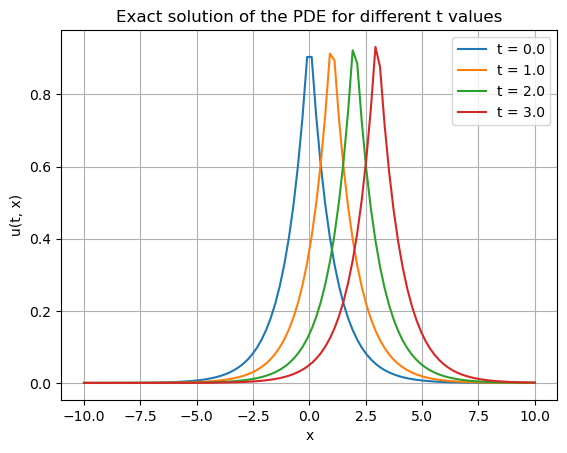

In [32]:
for t in t_values:
    u_values = np.exp(-np.abs(x_range - [t]))
    plt.plot(x_range, u_values.flatten(), label=f't = {t}')

plt.xlabel('x')
plt.ylabel('u(t, x)')
plt.title('Exact solution of the PDE for different t values')
plt.legend()
plt.grid(True)
plt.show()